In [53]:
# !pip install matplotlib

In [69]:
import SimpleITK as sitk
import numpy as np
import os
import matplotlib.pyplot as plt
import math
import matplotlib.animation as animation

In [70]:
# image
# Image = sitk.ReadImage("test.nii.gz")
# sitk.Show(Image)
# space = Image.GetSpacing()
# voxel_volume = space[0]*space[1]*space[2]


In [108]:
# img1 = sitk.ReadImage("Temporal 75 Cal Score .625 DLIR SSF - 306.nii.gz")
img1 = sitk.ReadImage('../CAC_cases_2500_vs_625_group1_originals/ID27649_CAC/img-nii/Temporal 75 Cal Score .625 DLIR SSF - 306.nii.gz')
img2 = sitk.GetImageFromArray(sitk.GetArrayViewFromImage(img1)[0,:,:,:])
mask1 = sitk.ReadImage("../CAC_cases_2500_vs_625_group1_originals/ID27649_CAC/img-nii/Segmentation-Temporal75-label.nii.gz")
space = img1.GetSpacing()
voxel_volume = space[0]*space[1]*space[2]

pixelID = img1.GetPixelID()

gaussian = sitk.SmoothingRecursiveGaussianImageFilter()
gaussian.SetSigma(2)
blur_image = gaussian.Execute(img2)

caster = sitk.CastImageFilter()
caster.SetOutputPixelType(pixelID)
blur_image = caster.Execute(blur_image)

In [109]:
# sitk.GetImageFromArray(sitk.GetArrayViewFromImage(img1)[0,:,:,:])

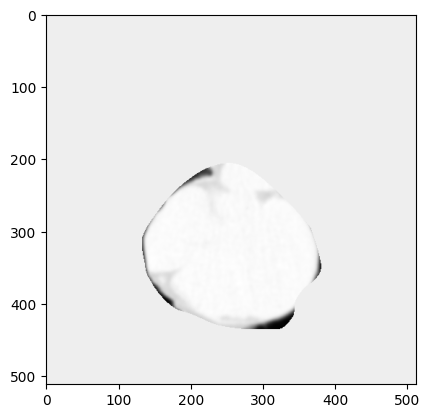

In [110]:
image_array = sitk.GetArrayViewFromImage(blur_image)
mask_array = sitk.GetArrayFromImage(mask1)
cropped_array = image_array * mask_array
# Display the image using Matplotlib
plt.imshow(cropped_array[120,:,:], cmap="gray")
plt.show()  
# # Display the image using Matplotlib
# plt.imshow(mask_array[40,130:450,20:450], cmap="gray")
# plt.show()  

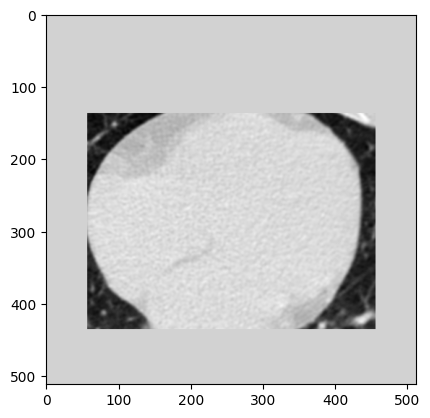

In [87]:
# def dist(l1, l2,):
#     return [np.sqrt((l1[0]-l2[0])**2) , np.sqrt((l1[1]-l2[1])**2) , np.sqrt((l1[2]-l2[2])**2 )]

# mask = np.zeros(image_array.shape)
# mask.shape
# # heart_array = image_array[:,130:450,20:450]
# # circular kernel 
# centre = [mask.shape[0]//2,mask.shape[1]//2+30, mask.shape[2]//2]
# radius = [50, 150, 200]
# for i in range(mask.shape[0]):
#     for j in range(mask.shape[1]):
#         for k in range(mask.shape[2]):

#             a,b,c = dist([i,j,k], centre) 
#             if a< radius[0] and b<radius[1] and c<radius[2]:
#                 mask[i,j,k]=1

# heart_array = image_array * mask


# # calcim = heart_array > 130

# # Display the image using Matplotlib
# plt.imshow(heart_array[54,:,:], cmap="gray")
# plt.show()  




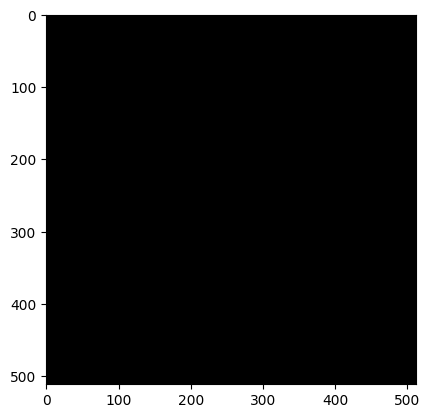

In [88]:
def make_movie(heart_array, filename):
    # Create a 3D numpy array

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Initialize an empty list to store the frames
    ims = []

    # Iterate over the slices
    for i in range(heart_array.shape[0]):
        im = ax.imshow(heart_array[i, :,:], animated=True, cmap="gray")
        ims.append([im])

    # Create the animation
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

    # Save the animation as a video file (e.g., MP4)
    ani.save(f'{filename}.mp4', writer='ffmpeg')

    # Display the animation
    plt.show()

make_movie(cropped_array, "heart_original_ID27649_temporal")

In [68]:
calcium_mask =heart_array[heart_array > 130]

In [73]:
# plt.imshow(calcium_mask[55], cmap='gray')
# plt.show()
# Image.GetSpacing()[1]

0.29296875

In [111]:
def calculate_agatston_score_aorta(ct_scan, voxel_volume, calcium_mask_location="calcium_mask.nii.gz"):
    """
    Calculates the Agatston score of a cropped CT scan specifically for the aorta region.

    Args:
        ct_scan: A 3D numpy array representing the CT scan intensity values of the aorta region.
        voxel_volume: The volume in centimetres cubed (cm^3) of one voxel.

    Returns:
        A tuple containing:
            - The Agatston score: An integer representing the total Agatston score.
            - The Calcium Volume: A float representing the total volume (cm^3) of calcium detected.
    """

    # Thresholds for calcium detection at different attenuation levels
    # global calcium_threshold  # This variable should likely be defined elsewhere
    calcium_threshold = 130 ; 

    thresh = [130, 200, 300, 400]  # Thresholds for classifying calcium based on attenuation

    # Identify calcium pixels using SimpleITK for potential future conversion
    # This line is currently commented out as the code uses numpy for efficiency
    # filter = sitk.BinaryThresholdImageFilter()
    # calcium_mask = ct_scan
    # binaryFilter = sitk.BinaryThresholdImageFilter()
    # binaryFilter.SetInsideValue(1)
    # binaryFilter.SetLowerThreshold(calcium_threshold)
    # binaryFilter.SetOutsideValue(0)
    # ct_image_fitered = binaryFilter.Execute(calcium_mask)
    #
    # # Save the calcium mask for visualization purposes (optional)
    # sitk.WriteImage(ct_image_fitered, calcium_mask_location)

    # Efficiently identify calcium pixels using numpy
    calcium_mask = np.where(ct_scan > calcium_threshold, 1, 0)
    print(np.sum(calcium_mask))
    # Convert the 3D CT scan to a flat array for easier processing
    ct_scan_2 = ct_scan.flat  # Flatten the 3D array

    # Calculate area of each calcium lesion and assign weights based on attenuation
    # Assign weights (labels) based on the intensity of the calcium pixels
    labeled_calcium = np.where(ct_scan_2 >= thresh[3], 4,  # Highest attenuation gets weight 4
                       np.where(ct_scan_2 >= thresh[2], 3,  # Second highest gets weight 3
                            np.where(ct_scan_2 >= thresh[1], 2,  # Middle gets weight 2
                                 np.where(ct_scan_2 >= thresh[0], 1, 0))))  # Lowest gets weight 1
    
    calcium_image = ct_scan * calcium_mask
    # Count the number of pixels in each calcium class and multiply by the weight (area)
    # This efficiently calculates the total area and volume of calcium at each level
    calcium_areas = np.bincount(labeled_calcium, weights=labeled_calcium)
    calcium_volumes = np.bincount(labeled_calcium.flat)[1:] * voxel_volume  # Extract volumes (excluding background)

    # Print calcium areas for debugging purposes (optional)
    # print("Areas", calcium_areas)

    # Calculate the Agatston score and calcium volume

    
    agaston_score = np.sum(calcium_areas) * voxel_volume  # Total area times voxel volume
    calcium_volume = np.sum(calcium_volumes)  # Total volume of calcium
    # sitk.WriteImage(sitk.GetImageFromArray(calcium_mask),calcium_mask_location )
    return agaston_score, calcium_volume, calcium_image

In [117]:
ag_score , volume, calcium_image = calculate_agatston_score_aorta(cropped_array, voxel_volume, calcium_mask_location='calcium_mask_image_2')

print(ag_score , volume)

544
102.22186596368083 81.06223773213173


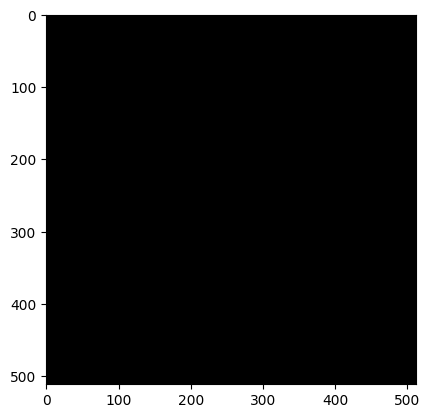

In [113]:
make_movie(calcium_image, "calcium_mask_image_ID27649")


(array([6.6581917e+07, 1.5970000e+03, 5.4800000e+02, 2.0800000e+02,
        1.1600000e+02, 6.9000000e+01, 5.0000000e+01, 3.3000000e+01,
        2.9000000e+01, 9.0000000e+00]),
 array([   0.,  197.,  394.,  591.,  788.,  985., 1182., 1379., 1576.,
        1773., 1970.]),
 <BarContainer object of 10 artists>)

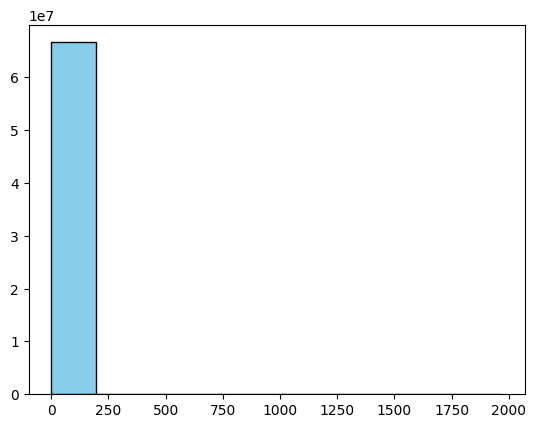

In [23]:
# Plotting a basic histogram
# plt.hist(calcium_image.flat, color='skyblue', edgecolor='black')
 

In [114]:
# Get the array from the image
calcium_image_array_mask = np.where(cropped_array > 130, 1,0) #sitk.GetArrayFromImage(calcium_image)
calcium_image_array = calcium_image_array_mask * cropped_array
# Flatten the 3D array to 1D for histogram
flattened_array = calcium_image_array.flatten()



In [115]:
flattened_array.mean()
flattened_array.max()


np.float64(304.8467102050781)

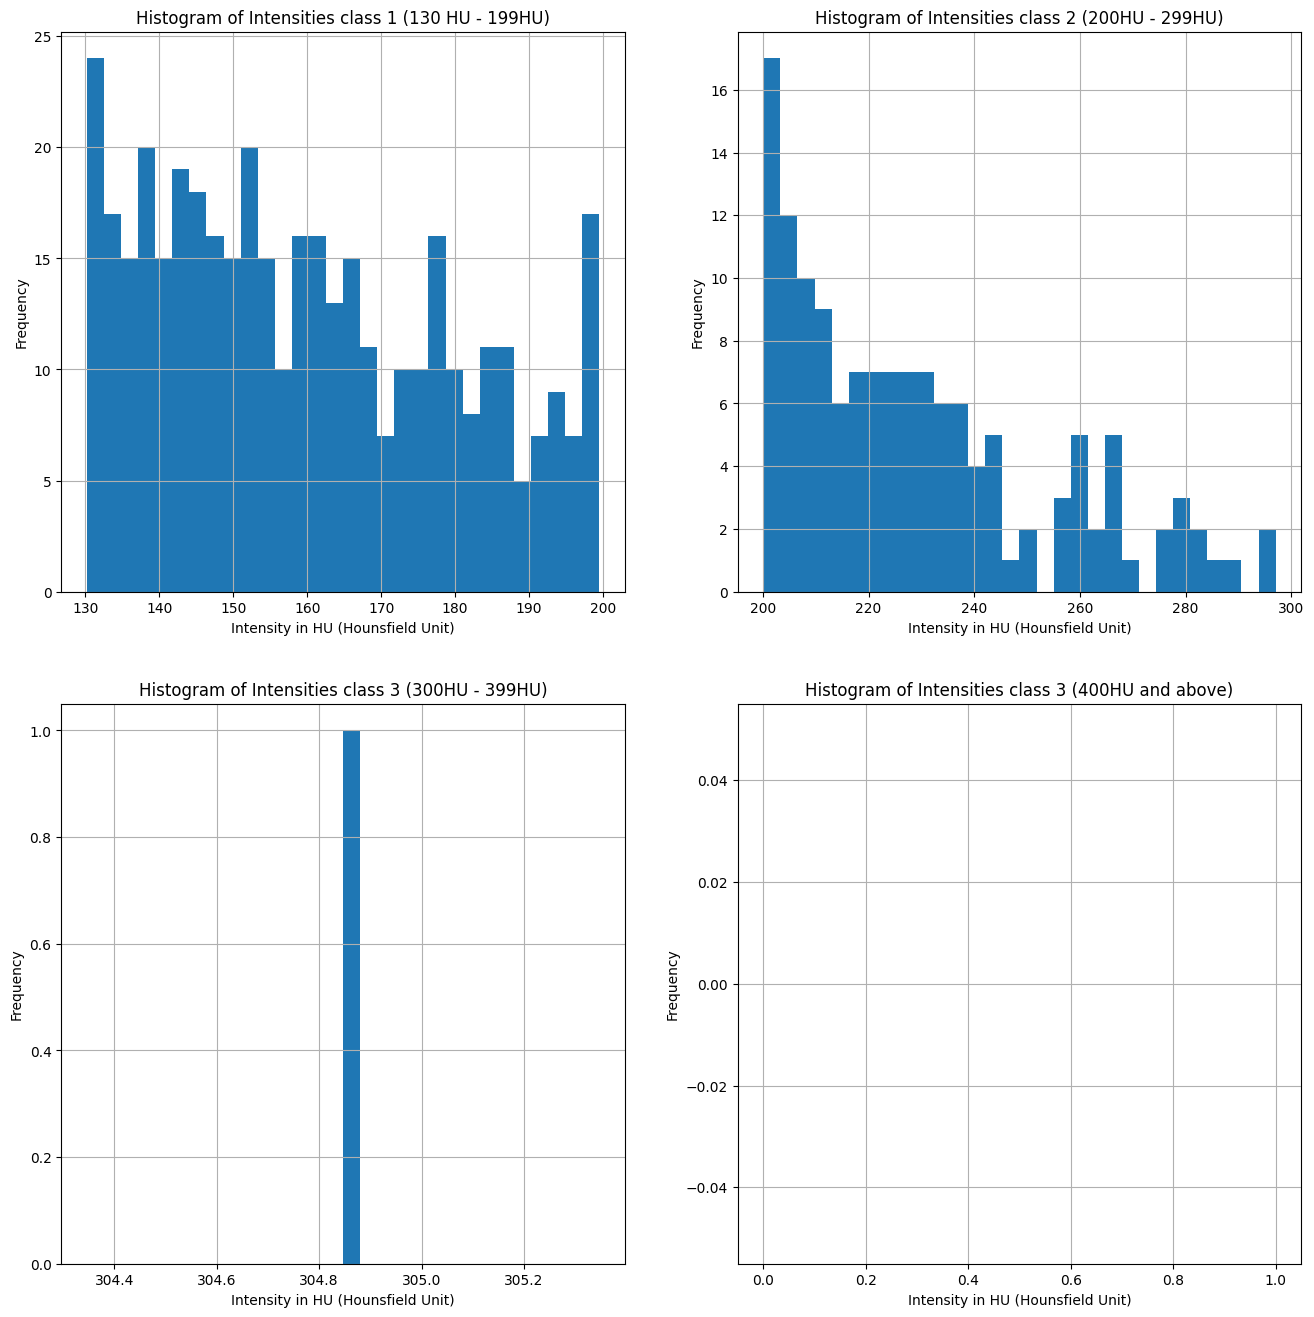

In [116]:
# Plot the histogram
# plt.figsize(16,16)
plt.figure(figsize=(16,16))
plt.subplot(2, 2, 1,)
plt.grid()
plt.hist(flattened_array[(flattened_array>130)&(flattened_array<200)], bins=30)
plt.xlabel("Intensity in HU (Hounsfield Unit)")
plt.ylabel("Frequency")
plt.title("Histogram of Intensities class 1 (130 HU - 199HU)")
# plt.show()

plt.subplot(2, 2, 2)
# Plot the histogram
plt.grid()
plt.hist(flattened_array[(flattened_array>200)&(flattened_array<300)], bins=30)
plt.xlabel("Intensity in HU (Hounsfield Unit)")
plt.ylabel("Frequency")
plt.title("Histogram of Intensities class 2 (200HU - 299HU)")
# plt.show()

plt.subplot(2, 2, 3)
# Plot the histogram
plt.grid()
plt.hist(flattened_array[(flattened_array>300)&(flattened_array<400)], bins=30)
plt.xlabel("Intensity in HU (Hounsfield Unit)")
plt.ylabel("Frequency")
plt.title("Histogram of Intensities class 3 (300HU - 399HU)")
# plt.show()

plt.subplot(2, 2, 4)
# Plot the histogram
plt.grid()
plt.hist(flattened_array[(flattened_array>400)], bins=100)
plt.xlabel("Intensity in HU (Hounsfield Unit)")
plt.ylabel("Frequency")
plt.title("Histogram of Intensities class 3 (400HU and above)")
plt.show()